### Imports

In [1]:
from keras import Model
from keras import backend
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from keras.layers import Dense, Input, Conv2D, Concatenate, Flatten, BatchNormalization, Embedding, Activation, Dropout, LeakyReLU, ReLU, Reshape, Conv2DTranspose, concatenate, MaxPooling2D
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os, time, random, zipfile, cv2
import pandas as pd

from google.colab import files
from urllib import request
from google.colab import drive
from scipy.linalg import sqrtm
from PIL import Image, ImageOps

print(tf.__version__)

2.4.1


### Paths

In [37]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")
dataset_path = os.path.join(dataset_folder, "celeba.zip")
extract_path = os.path.join(dataset_folder, "img_align_celeba")
cropped_path = os.path.join(dataset_folder, "Cropped")
attributes_path = os.path.join(dataset_folder, "list_attr_celeba.csv")
generated_images_path = os.path.join(os.getcwd(), "Generated images")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

if not os.path.exists(cropped_path):
    os.makedirs(cropped_path)

if not os.path.exists(generated_images_path):
    os.makedirs(generated_images_path)

dataset_url =  "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"

## Dataset download and preprocessing

In [38]:
def download_dataset(download_path, url):
  if not os.path.exists(download_path):
    print("Downloading dataset...", end=" ")
    request.urlretrieve(url, download_path)
    print("Done!")
  else:
    print("Already downloaded")

def extract_dataset(download_path, extract_path):
  if not os.path.exists(extract_path):
    print("Extracting dataset...", end=" ")
    with zipfile.ZipFile(download_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Done!")
  else:
    print("Already extracted")

# Download
download_dataset(dataset_path, dataset_url)

# Extraction
extract_dataset(dataset_path, dataset_folder)

Already downloaded
Already extracted


In [23]:
def crop(source_path, dest_path):
  if not os.path.isdir(dest_path):
    os.mkdir(dest_path)
  if len(os.listdir(dest_path)) == 0:
    images = os.listdir(source_path)
    for img_path in images:
      img = Image.open(source_path + "/" + img_path)
      f, e = os.path.splitext(img_path)
      imCrop = img.crop((25, 45, 128 + 25, 128 + 45)) 
      imCrop.save(dest_path + "/" + f + '.jpg', "JPEG", quality=100)

crop(extract_path, cropped_path)

In [11]:
drive.mount('/content/drive')

Mounted at /content/MyDrive


In [12]:
!cp '/content/drive/MyDrive/list_attr_celeba.csv' '/content/Dataset'

In [170]:
def load_attributes(path):
  df = pd.read_csv(path)
  ids = df['image_id'] 
  attributes = df.drop(columns=['image_id'])
  attributes.replace(to_replace=-1, value=0, inplace=True)
  attributes = attributes.apply(lambda x: x.to_numpy(), axis=1)
  df = pd.DataFrame(columns = ['file_id', 'attributes'])
  df['file_id'] = ids
  df['attributes'] = attributes
  return df
  
attributes = load_attributes(attributes_path)
attributes_list = pd.read_csv(attributes_path).drop(columns=['image_id']).columns
attributes_dict = dict(enumerate(attributes_list))

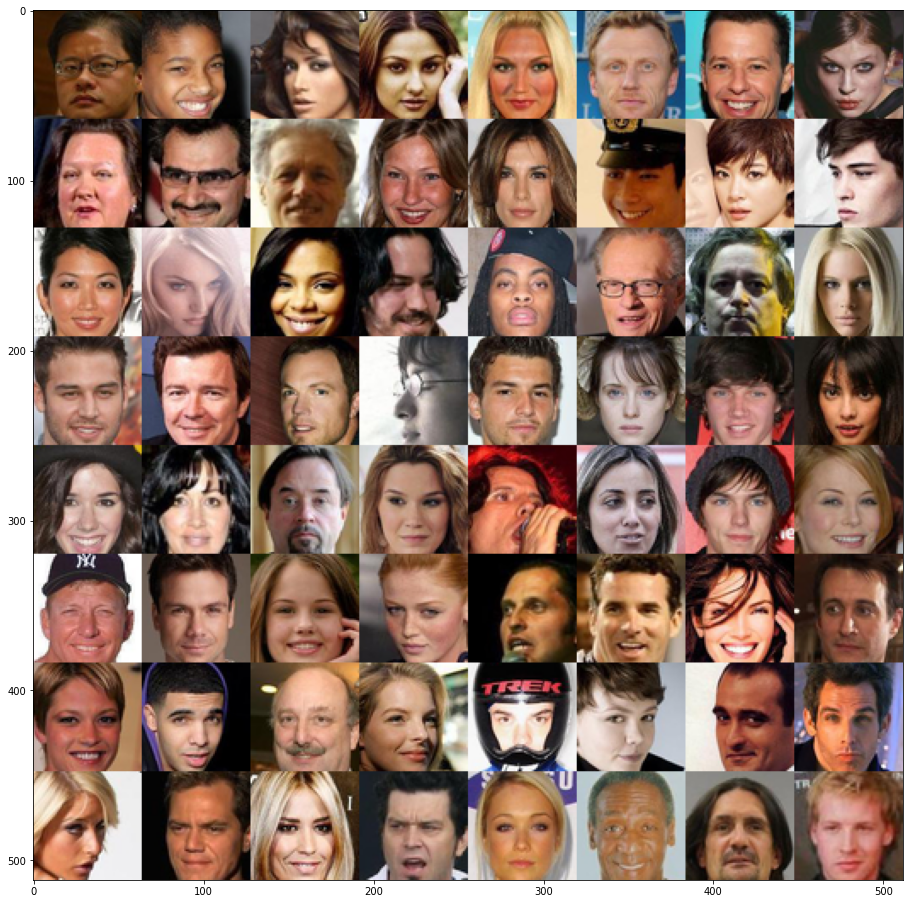

In [171]:
def concat_images(images, size, shape=None):
    # Open images and resize them
    width, height = size
  
    # Create canvas for the final image with total size
    shape = shape if shape else (1, len(images))
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    
    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            image.paste(images[idx], offset)
    
    return image

# Get list of image paths
image_paths = [os.path.join(cropped_path, f) 
               for f in os.listdir(cropped_path) if f.endswith('.jpg')]

# Random selection of images
image_array = random.choices(image_paths, k=84)

images = map(Image.open, image_array)
images = [ImageOps.fit(image, (64, 64), Image.ANTIALIAS) 
              for image in images]

# Create and save image grid
image = concat_images(images, (64, 64), (8, 8))
plt.figure(figsize = (16,16))
plt.imshow(image)

In [172]:
def load_dataset(cropped_path, attributes, batch_size, image_shape, subset=False):
    dataset_generator = ImageDataGenerator()
    if subset:
      dataset_generator = dataset_generator.flow_from_dataframe(
        dataframe=attributes[0:20000], directory=cropped_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size, x_col='file_id', y_col='attributes', class_mode='raw')
    else:
      dataset_generator = dataset_generator.flow_from_dataframe(
        dataframe=attributes, directory=cropped_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size, x_col='file_id', y_col='attributes', class_mode='raw')

    return dataset_generator

## Gan section

### Function to save generated images

In [173]:
def save_generated_images(generated_images, epoch, batch_number, batch_size):

  plt.figure(figsize=(8, 8), num=2)
  gs1 = gridspec.GridSpec(8, 8)
  gs1.update(wspace=0, hspace=0)

  for i in range(batch_size):
      ax1 = plt.subplot(gs1[i])
      ax1.set_aspect('equal')
      image = generated_images[i, :, :, :]
      image += 1
      image *= 127.5
      fig = plt.imshow(image.astype(np.uint8))
      plt.axis('off')
      fig.axes.get_xaxis().set_visible(False)
      fig.axes.get_yaxis().set_visible(False)
      
  plt.tight_layout()
  save_name = 'generated images/epoch_' + str(
      epoch + 1) + '_batch_' + str(batch_number + 1) + '.png'

  plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
  plt.pause(0.0000000001)
  plt.show()

### Wasserstein loss

In [174]:
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

### FID function

In [175]:
def scale_images(images, new_shape):
  images_list = list()

  for image in images:
    # resize with bilinear interpolation
	  new_image = cv2.resize(image, (new_shape, new_shape))
    # store
	  images_list.append(new_image)
  return np.asarray(images_list)

def calculate_fid(model, images1, images2):
  # scale images
  images1 = scale_images(images1, 299)
  images2 = scale_images(images2, 299)

  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)

  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)

  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)

  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))

  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real

  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

### Real and Fake data generation

In [176]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  
  # generate labels
  labels = np.array(random.sample(list(attributes['attributes']), n_samples))
  
  return [x_input, labels]

def generate_real_samples(dataset):
  X, label = dataset.next()
  X /= 127.5
  X -= 1
  y = -np.ones(X.shape[0])
  return [X, label], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, custom_label=None):
  
  # generate points in latent space
  x_input, labels = generate_latent_points(latent_dim, n_samples)
  
  # predict outputs
  if custom_label is not None:
    labels = np.tile(custom_label, (n_samples,1))
  
  X = generator.predict([x_input, labels])
  
  # create class labels
  y = np.ones((n_samples, 1))
  
  return [X, labels], y

### Discriminator, Generator and GAN

In [177]:
# define the standalone discriminator model
class ClipConstraint(Constraint):
  # set clip value when initialized
  def __init__(self, clip_value):
    self.clip_value = clip_value

  # clip model weights to hypercube
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)

  # get the config
  def get_config(self):
    return {'clip_value': self.clip_value}

def define_discriminator(in_shape=(64,64,3), label_shape=(40,), n_attributes=40):
  #input_label = Input(shape=label_shape)
  
  init = RandomNormal(stddev=0.02)

  input_image = Input(shape=in_shape)

  #input_label = Embedding(n_attributes, 100)(input_label)
  #input_label = Reshape()(input_label)
  
  # define the constraint
  const = ClipConstraint(0.01)

	# downsample
  d = Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=in_shape, kernel_initializer=init, kernel_constraint=const)(input_image)
  d = LeakyReLU(alpha=0.2)(d)
  d = Dropout(0.2)(d)
	
  # downsample
  d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Dropout(0.2)(d)
  
  # downsample
  d = Conv2D(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Dropout(0.2)(d)
  
  # downsample
  d = Conv2D(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Dropout(0.2)(d)
  
  # downsample
  d = Conv2D(256, (4,4), strides=(1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Dropout(0.2)(d)
  
  # classifier
  d = Flatten()(d)
  #d = Concatenate()([d, input_label])
  d = Dropout(0.4)(d)
  out1 = Dense(1, activation='linear')(d)
  out2 = Dense(n_attributes, activation='sigmoid')(d)
	
  # compile model
  opt = RMSprop(lr=0.00005)

  model = Model(input_image,  [out1, out2])
  
  model.compile(loss=[wasserstein_loss, 'categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
  return model
 
# define the standalone generator model
def define_generator(latent_dim, n_attributes=40):
  input_label = Input(shape=(40,))

  init = RandomNormal(stddev=0.02)
  
  image_input = Input(shape=(latent_dim,))
  
  merged_input = Concatenate()([image_input, input_label])  
  
  hid = Dense(140 * 8 * 8, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.8)(hid)
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Reshape((8, 8, 140))(hid)
  
  # upsample to 16x16
  conv = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(hid)
  conv = BatchNormalization(momentum=0.8)(conv)
  conv = LeakyReLU(alpha=0.2)(conv)
  
  # upsample to 32x32
  conv = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(conv)
  conv = BatchNormalization(momentum=0.8)(conv)
  conv = LeakyReLU(alpha=0.2)(conv)
  
  # upsample to 64x64
  conv = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(conv)
  conv = LeakyReLU(alpha=0.2)(conv)
  
  # generate
  act = Conv2D(3, (16,16), activation='tanh', padding='same', kernel_initializer=init)(conv)
  
  model = Model([image_input, input_label], act)
  
  return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	
  # make weights in the discriminator not trainable
  for layer in discriminator.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  gen_image, gen_label = generator.input

  gen_output = generator.output
  gan_output = discriminator([gen_output, gen_label])

  model = Model([gen_image, gen_label], gan_output)
  
	# compile model
  opt = RMSprop(lr=0.00005)
  model.compile(loss=[wasserstein_loss, 'categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
  return model

## Train

In [187]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, inception_model, dataset, latent_dim, n_epochs=10, n_batch=64):
    bat_per_epo = int(202599 / n_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
      start = time.time()

      # enumerate batches over the training set
      for j in range(bat_per_epo):

        # train discriminator 3 times as the generator
        for k in range(3):
          # get randomly selected 'real' samples
          [X_real, labels_real], y_real = generate_real_samples(dataset)
          current_batch_size = X_real.shape[0]
          
          print(np.expand_dims(labels_real, axis=-1).shape)
          
          labels_real = labels_real.reshape(current_batch_size, 40, 1)
          # update discriminator model weights
          d_loss1, _, _, _, _ = d_model.train_on_batch(X_real, [y_real, labels_real])
          
          
          # generate 'fake' examples
          [X_fake, labels_fake], y_fake = generate_fake_samples(
              g_model, latent_dim, current_batch_size)
          
          labels_fake = labels_fake.reshape(current_batch_size, 40, 1)
          # update discriminator model weights
          d_loss2, _, _, _, _ = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
          
        # prepare points in latent space as input for the generator
        X_gan, label_gan = generate_latent_points(latent_dim, current_batch_size)
        # create inverted labels for the fake samples
        y_gan = -np.ones((current_batch_size, 1))
        # update the generator via the discriminator's error
        g_loss, _ = gan_model.train_on_batch([X_gan, label_gan], [y_gan, label_gan])
        # summarize loss on this batch
        if ((j + 1) % 200 == 0):
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
              (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

        if ((j + 1) % 1000 == 0):
            save_generated_images(X_fake, i, j, n_batch)
      
      end = time.time()
      print("Elapsed time: {} minutes and {:.2f} seconds".format((end-start)//60, (end-start)%60))
    
      # save the generator model
      g_model.save('/content/drive/MyDrive/Generators/generator_epoch_'+str(i+1)+'.h5')
 
# size of the latent space
latent_dim = 100

# create the discriminator
discriminator = define_discriminator()

# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)

# load image data
dataset = load_dataset(cropped_path, attributes, 64, (64,64,3), subset=True)

# prepare the inception model
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# train model
train(generator, discriminator, gan_model, inception, dataset, latent_dim, n_epochs=15, n_batch=64)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3074 invalid image filename(s) in x_col="file_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 16926 validated image filenames.
(64, 1)


ValueError: ignored

# Test

## FID value

In [26]:
i = 11
generator = load_model('/content/drive/MyDrive/Generators/generator_epoch_11.h5')

real_for_fid = []
fake_for_fid = []

for i in range(10000//64):
  [real, label_real], _ = generate_real_samples(dataset)
  [fake, label_fake], _ = generate_fake_samples(generator, latent_dim, 64)
  real_for_fid.append(real)
  fake_for_fid.append(fake)

real_images = np.array(real_for_fid).reshape(len(real_for_fid)*64 , 64, 64, 3)
fake_images = np.array(fake_for_fid).reshape(len(fake_for_fid)*64 , 64, 64, 3)
fid = calculate_fid(inception, real, fake)
print("Fid score calculated on {} real images and {} fake images: {:.2f}".format(real_images.shape[0], fake_images.shape[0], fid))

Fid score: 1.07


## Custom label generation

In [ ]:
def create_custom_label(attr):
  label = []
  for k,v in attributes_dict.items():
    if v in attr:
      label.append(1)
    else:
      label.append(0)
  return np.array(label)

.      |           |    |           |    |           |    |         .
-------|-----------|----|-----------|----|-----------|----|----------
5_o_Clock_Shadow | Blurry | Male | Sideburns
Arched_Eyebrows | Brown_Hair | Mouth_Slightly_Open | Smiling
Attractive | Bushy_Eyebrows | Mustache | Straight_Hair
Bags_Under_Eyes | Chubby | Narrow_Eyes | Wavy_Hair
Bald | Double_Chin | No_Beard | Wearing_Earrings
Bangs | Eyeglasses | Oval_Face | Wearing_Hat
Big_Lips | Goatee | Pale_Skin | Wearing_Lipstick
Big_Nose | Gray_Hair | Pointy_Nose | Wearing_Necklace
Black_Hair | Heavy_Makeup | Receding_Hairline | Wearing_Necktie
Blond_Hair | High_Cheekbones | Rosy_Cheeks | Young

[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1]
Fid score: 2.78


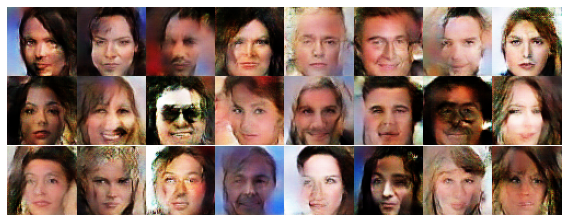

In [ ]:
custom_attributes = ['Attractive', 'Big_Lips', 'Black_hair', 'Male', 'Young', 'Wavy_Hair', 'No_Beard', 'Smiling']

custom_label = create_custom_label(custom_attributes)
[real, label_real], _ = generate_real_samples(dataset)
[fake, label_fake], _ = generate_fake_samples(generator, latent_dim, 64, custom_label=custom_label)
fid = calculate_fid(inception, real, fake)
save_generated_images(fake, 0, 0, 24)